In [1]:
#prepare fast.ai
!curl https://course.fast.ai/setup/colab | bash

#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
#  4/uAEX5fiE4XmV7J7-0InpsjpHILe-NhsBHSDsPXflvXGdEh4ChdR8uOc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1262      0 --:--:-- --:--:-- --:--:--  1262
Updating fastai...
Done.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [0]:
path = Path('/content/gdrive/My Drive/DATA/rossmann')
train_df = pd.read_pickle(path/'train_clean')

In [4]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [5]:
n = len(train_df); n

844338

### Experimenting with a sample

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [7]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
25,26,5,NaN,2300.0,62,7818
293,295,5,"Mar,Jun,Sept,Dec",210.0,51,7687
1751,640,4,NaN,8040.0,73,10850
2437,212,3,NaN,15050.0,75,5551
2917,693,3,"Jan,Apr,Jul,Oct",450.0,54,7470


In [8]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
426696,311,3,NaN,680.0,63,5744
426875,490,3,"Jan,Apr,Jul,Oct",660.0,78,6628
427158,776,3,"Jan,Apr,Jul,Oct",700.0,71,3519
428057,564,2,"Jan,Apr,Jul,Oct",6540.0,69,3959
428061,568,2,"Jan,Apr,Jul,Oct",4270.0,78,3724


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
426696,311,3,NaN,680.0,63,5744
426875,490,3,"Jan,Apr,Jul,Oct",660.0,78,6628
427158,NaN,3,"Jan,Apr,Jul,Oct",700.0,71,3519
428057,NaN,2,"Jan,Apr,Jul,Oct",6540.0,69,3959
428061,568,2,"Jan,Apr,Jul,Oct",4270.0,78,3724


In [11]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [12]:
small_train_df['PromoInterval'].cat.codes[:5]

25     -1
293     2
1751   -1
2437   -1
2917    1
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [15]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
128841,622,5,NaN,2620.0,78,4533,True
157492,291,3,NaN,2620.0,86,6521,True
209456,291,5,NaN,2620.0,68,8174,True


### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [17]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [21]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [22]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [24]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [26]:
data

TabularDataBunch;

Train: LabelList (802943 items)
x: TabularList
Store 1115; DayOfWeek 5; Year 2015; Month 6; Day 19; StateHoliday False; CompetitionMonthsOpen 0; Promo2Weeks 25; StoreType d; Assortment c; PromoInterval Mar,Jun,Sept,Dec; CompetitionOpenSinceYear 1900; Promo2SinceYear 2012; State HE; Week 25; Events Rain; Promo_fw 1.0; Promo_bw 5.0; StateHoliday_fw 0.0; StateHoliday_bw 0.0; SchoolHoliday_fw 0.0; SchoolHoliday_bw 0.0; CompetitionDistance_na False; CloudCover_na False; CompetitionDistance -0.0130; Max_TemperatureC 0.1333; Mean_TemperatureC 0.4683; Min_TemperatureC 0.8602; Max_Humidity 0.0780; Mean_Humidity -0.3412; Min_Humidity -0.0811; Max_Wind_SpeedKm_h -0.1780; Mean_Wind_SpeedKm_h 0.1902; CloudCover 0.2552; trend 0.4066; trend_DE 0.5969; AfterStateHoliday -0.7329; BeforeStateHoliday 1.1848; Promo 1.1119; SchoolHoliday -0.4796; ,Store 1; DayOfWeek 4; Year 2015; Month 6; Day 18; StateHoliday False; CompetitionMonthsOpen 24; Promo2Weeks 0; StoreType c; Assortment a; Prom

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [29]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [30]:
len(data.train_ds.cont_names)

16

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


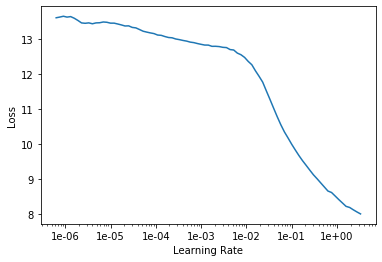

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.027529,0.030438,0.152709,04:06
1,0.018503,0.017622,0.123548,04:08
2,0.015966,0.019785,0.127203,04:10
3,0.012597,0.012963,0.107837,04:11
4,0.010169,0.010745,0.102086,04:12


In [0]:
learn.save('1')

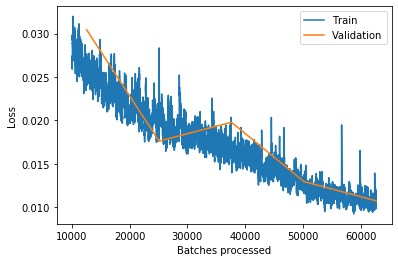

In [36]:
learn.recorder.plot_losses(skip_start=10000)

In [0]:
learn.load('1');

In [37]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013486,0.012897,0.108540,04:11
1,0.011320,0.011910,0.107555,04:11
2,0.013827,0.012907,0.106575,04:12
3,0.009832,0.011494,0.104568,04:10
4,0.008456,0.011553,0.105815,04:09


In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011840,0.013236,0.110483
2,0.010765,0.057664,0.129586
3,0.010101,0.042744,0.111584
4,0.008820,0.116893,0.135458
5,0.009144,0.017969,0.126323


(10th place in the competition was 0.108)

In [40]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)